# Libraries

In [1]:
# Standards
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Boosted Decision Tree (BDT)
import lightgbm as lgb

# Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

In [3]:
#Simple timer for LGBM

import time
class Timer:
    def __init__(self,every=100):
        self.start = time.time()
        self.every = every
        
    def __call__(self,CallbackEnv):
        i = CallbackEnv.iteration
        if i%self.every == 0:
            print(f"Iteration: {i}")
            self.print_time()
            
    def print_time(self):
        print(f"Total time elapsed: {time.time()-self.start:.2f}s")

# Prework

## Loading data

In [4]:
data_all = pd.read_hdf("ATLAS_electrons.h5").sample(5_000)
display(data_all)

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge,p_Truth_isElectron,p_Truth_Energy
172497,29.490000,0.006718,0.026193,0.000000,0.054068,0.625889,0.836770,0.000000,0.000000,-0.097580,...,18294.822266,239.670013,9002.840820,9113.384766,1317.603516,1.454916,1.703152,-1.0,0,2916.638428
67340,37.500000,-0.002204,-0.009120,0.003410,0.014752,0.877439,0.542746,0.275275,0.197798,-0.072509,...,43362.617188,1524.436890,4869.293945,13304.446289,18107.537109,-0.991766,-2.245026,1.0,0,26767.714844
119106,34.500000,0.098419,0.142946,0.014004,0.013543,0.750598,0.697579,0.808780,0.203916,-0.038615,...,22418.613281,810.930176,5302.758301,7898.355469,15024.003906,0.380884,0.976049,1.0,0,17123.576172
137425,39.490002,0.092709,0.209562,0.007203,0.014040,0.902826,0.915061,0.526066,0.360787,-0.037350,...,86139.179688,674.529358,20955.705078,55512.652344,10434.353516,1.633798,-0.191572,-1.0,0,26361.207031
155311,28.500000,0.963839,1.863222,0.005756,0.007542,0.706500,0.798318,0.639180,0.352764,-0.001953,...,21003.601562,199.721298,1276.593750,11071.308594,779.737732,0.362694,-3.139733,-1.0,0,16043.537109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84495,24.500000,0.022488,0.031622,0.023940,0.015286,0.786326,0.725014,0.441305,0.253335,-0.076716,...,44719.300781,1071.267822,3303.768555,15975.235352,8660.766602,0.568172,-1.510897,-1.0,0,10229.558594
2887,46.490002,0.009385,0.015745,0.006651,0.010740,0.899439,0.962124,0.946850,0.256107,0.223585,...,27502.328125,404.684784,596.121704,9638.987305,20045.511719,-0.890540,2.442335,-1.0,1,45560.277344
109855,33.500000,0.158087,0.264294,0.003334,0.011945,0.598607,0.700805,0.486729,0.307594,0.116732,...,33486.109375,1551.092773,4036.646240,16861.634766,20573.332031,-0.255003,0.581960,1.0,0,20931.560547
46058,25.490000,0.053696,0.061137,0.006639,0.012585,0.693220,0.696799,0.908291,0.191573,-0.104216,...,48220.343750,658.751831,6404.068848,10380.916992,11891.600586,-0.883669,2.284469,1.0,0,16692.304688


## Split data into labels and features

In [5]:
best_features = ['p_Rhad','p_sigmad0','p_TRTPID','p_deltaEta1','p_etcone20','p_numberOfInnermostPixelHits',
                 'p_Rhad1','pX_f3core','p_dPOverP','p_d0','pX_E3x5_Lr1','p_deltaPhiRescaled2','pX_deltaEta2',
                 'p_Reta','pX_topoetcone20','p_etcone30','pX_MultiLepton','p_Eratio','p_f3','pX_topoetcone40'][:10]

yelectron = data_all.pop("p_Truth_isElectron")
yenergy = data_all.pop("p_Truth_Energy")
X = data_all[best_features]

# Classification

## By hand

## LightGBM

First we split the data into training, validation, and test sets.

In [6]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X,yelectron,
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,
                                            test_size=0.25,random_state=314)

In [7]:
param = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'unbalanced_sets': True,
    'num_leaves': 475,
    'learning_rate': 0.0127,
    'feature_fraction': 0.49,
    'bagging_fraction': 0.957,
    'bagging_freq': 29,
    'min_child_samples': 7,
}

lgb_model = lgb.LGBMClassifier(**param,n_estimators=1000, random_state=42,verbosity=-1)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10), timer:=Timer()])
timer.print_time()

Iteration: 0
Total time elapsed: 0.05s
Training until validation scores don't improve for 10 rounds
Iteration: 100
Total time elapsed: 0.73s
Iteration: 200
Total time elapsed: 1.38s
Iteration: 300
Total time elapsed: 2.04s
Early stopping, best iteration is:
[336]	training's binary_logloss: 0.0169256	valid_0's binary_logloss: 0.116034
Total time elapsed: 2.79s


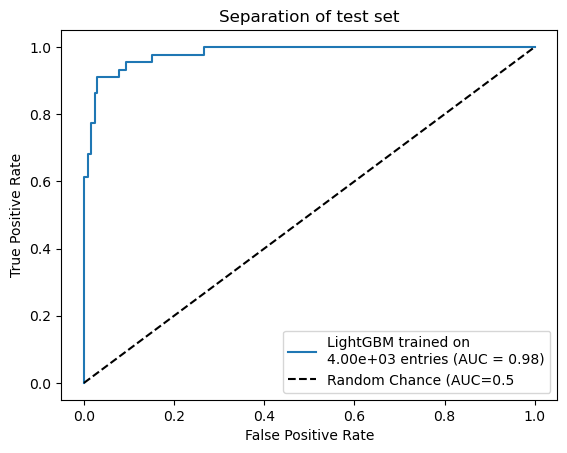

In [8]:
display_roc = RocCurveDisplay.from_predictions(
    ytest,
    ypred:= lgb_model.predict_proba(Xtest)[:,1],
    name=f"LightGBM trained on\n{len(ytrain):2.2e} entries",
)
display_roc.ax_.plot([0,1],[0,1],"k--",label="Random Chance (AUC=0.5")
display_roc.ax_.legend()
_ = display_roc.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Separation of test set"
)

By inspecting the model, we see that not all features are equally important. We also see, that the model didn't get to overtrain.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

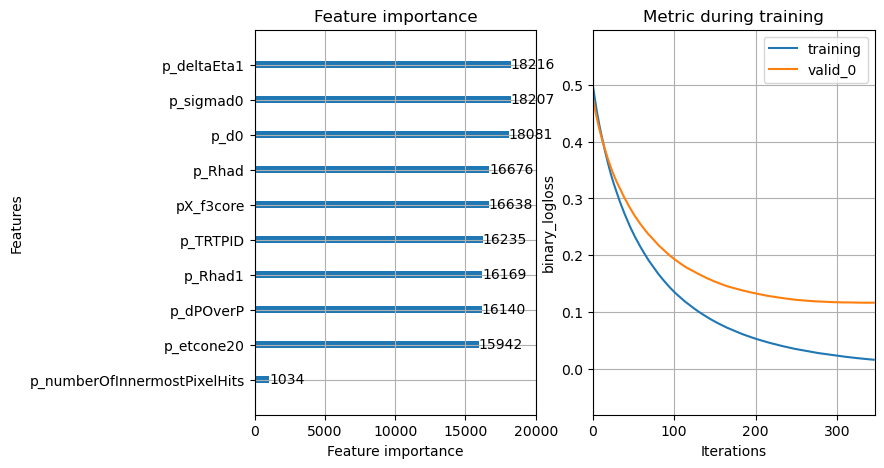

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
lgb.plot_metric(lgb_model,ax=ax[1])
lgb.plot_importance(lgb_model,ax=ax[0],max_num_features=40)

# Regression

## By hand

# LightGBM

As before we start by separating the data into sets for training, testing, and validating.

In [10]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X.loc[yelectron == 1],yenergy[yelectron==1], #Only train on particles that are actually electrons
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,test_size=0.25,random_state=314)

In [11]:
param = {
    'objective': 'regression',
    'unbalanced_sets': True,
    'num_leaves': 298,
    'learning_rate': 0.045,
    'feature_fraction': 0.64,
    'bagging_fraction': 0.97,
    'bagging_freq': 5,
    'min_child_samples': 2,
}

lgb_model = lgb.LGBMRegressor(**param,n_estimators=1000, random_state=42,verbosity=-1)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10),timer:=Timer(every = 50)])

Iteration: 0
Total time elapsed: 0.02s
Training until validation scores don't improve for 10 rounds
Iteration: 50
Total time elapsed: 0.28s
Iteration: 100
Total time elapsed: 0.60s
Early stopping, best iteration is:
[104]	training's l2: 3.31236e+06	valid_0's l2: 1.88693e+09


LGBMRegressor(bagging_fraction=0.97, bagging_freq=5, feature_fraction=0.64,
              learning_rate=0.045, min_child_samples=2, n_estimators=1000,
              num_leaves=298, objective='regression', random_state=42,
              unbalanced_sets=True, verbosity=-1)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

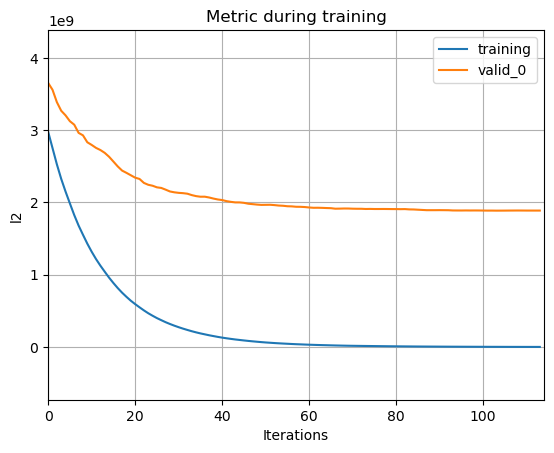

In [12]:
lgb.plot_metric(lgb_model)

In [13]:
energy_pred = lgb_model.predict(Xtest)

rel_dev = (energy_pred-ytest)/ytest

[(-2.0, 5.0), Text(0, 0.5, 'Counts/51'), Text(0.5, 0, 'Relative deviation')]

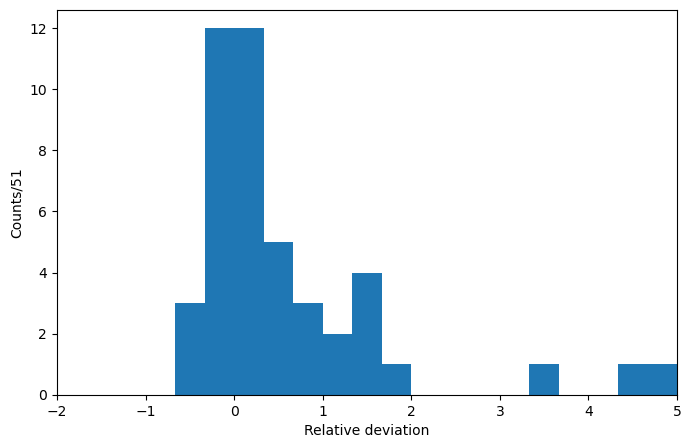

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
bins = np.linspace(-5,5,31)

xlabel = f"Relative deviation"
if largest:=np.min(rel_dev) > 5:
    bins[-1] = largest #Note that the last bin contains everything less than -5
    xlabel += f" - Zoomed in from {bins[0]:.2f}"
    
ax.hist(rel_dev, bins = bins)
ax.set(xlim=(-2,5),
      ylabel=f"Counts/{len(ytest)}",
      xlabel=xlabel)